In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pingouin as pg
import sys
from scipy.stats import shapiro
import pickle

In [2]:
# load file with plotting stlye definitions
sys.path.append('../')
plt.style.use('plotting_style.mpltstyle')
sns.set_style('whitegrid')

In [3]:
import warnings

# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Behavioral Analyses
This notebook contains all results and corresponding plots of the behavioral analyses based on frequentist summary statistics.

In [4]:
# load the data of each trial (including moves, reward, RT, time out, ID of performed sequence of actions)
df = pd.read_csv('../data_empirical/data_cleaned.csv', header=0)

### <u>OPTIONAL:</u> just participants best fit by EVPRM

In [ ]:
# use the behavior data file that was used for inference
df = pd.read_csv('../inference_data/data_behavior.csv', index_col=False)

In [34]:
# load df with best fit overview
dfModelComparison = pd.read_csv('../data_empirical/results_model_comparison_new.csv')

# get file names of participnats that are best fit by EVPRM
idxsEVPRM = dfModelComparison.loc[dfModelComparison['best_fit']=='EVPRM'].index
fileNamesEVPRM = dfModelComparison.loc[idxsEVPRM, 'file_name'].to_numpy()

# select corresponding data of participants best fit by EVPRM
df = df.loc[np.isin(df['file_name'], fileNamesEVPRM)]

In [35]:
# sanity check
len(df['file_name'].unique())

27

## 1 Create table with summary statistics
Calculate means over all participants for proportion of DAS choices p(DAS), reward per trial, reaction time (RT), and number of time outs. Divided into: whole task, halves and segments. Differences are checked for significance with paired $t$-tests (halves) and repeated measures ANOVAs (segments) using the corresponding methods from the <i>pingouin</i> package.
#### preparatory work

In [5]:
# add DAS indicator column to df
IdxDAS = 4 # set DAS index
df['DAS'] = np.where(df['sequence_ID']==IdxDAS, 1, 0)

# set RT and DAS of time out trials to NaN
df.loc[df['time_out']==1, ['RT', 'DAS']] = np.NaN

# add columns that code for the halfves and segments of the experiment
df['half'] = pd.cut(df['blockN'], 2, labels=np.arange(2))
df['segment'] = pd.cut(df['blockN'], 4, labels=np.arange(4))

# select the measures for analysis
measures = ['DAS', 'reward', 'RT', 'time_out']

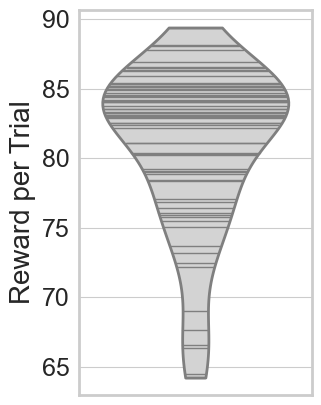

In [8]:
plt.figure(figsize=(3,5))

sns.violinplot(data=df['reward'].groupby(df['Participant_ID']).mean(), inner='stick', cut=0, color='lightgrey')

plt.ylabel('Reward per Trial', fontsize=20)
plt.xticks([])

plt.show()

In [9]:
# get minimum mean reward per trial
df['reward'].groupby(df['Participant_ID']).mean().min()

64.24375

### create table for statistics over the complete task

In [10]:
df[measures].groupby(df['Participant_ID']).mean().agg(['mean', 'std', 'median']).round(2)

,DAS,reward,RT,time_out
mean,0.54,80.69,1677.09,0.01
std,0.19,5.99,398.72,0.01
median,0.55,83.02,1639.15,0.01


In [11]:
df['time_out'].groupby(df['Participant_ID']).sum().agg(['mean', 'std']).round(2)

mean    4.74
std     3.70
Name: time_out, dtype: float64

In [12]:
# correlations (p-values on the upper triangle)
pg.rcorr(df[measures].groupby(df['Participant_ID']).mean(), stars=False)

,DAS,reward,RT,time_out
DAS,-,0.000,0.000,0.002
reward,0.66,-,0.000,0.000
RT,-0.567,-0.687,-,0.000
time_out,-0.37,-0.519,0.577,-


### create table for statistics depending on the half of the experiment

In [13]:
df[measures].groupby([df['Participant_ID'], df['half']]).mean().groupby('half').agg(['mean', 'std']).round(3)

DAS         reward               RT          time_out       
       mean    std    mean    std      mean      std     mean    std
half                                                                
0     0.533  0.197  79.579  6.664  1820.837  450.336    0.019  0.016
1     0.552  0.188  81.799  5.959  1535.595  390.854    0.010  0.012

In [14]:
df['time_out'].groupby([df['Participant_ID'], df['half']]).sum().groupby('half').agg(['mean', 'std']).round(2)

,mean,std
half,,
0,3.11,2.56
1,1.63,1.88


### look at p(DAS) depending on best fit by EVPRM

In [15]:
# load df with best fit overview
dfModelComparison = pd.read_csv('../data_empirical/results_model_comparison_new.csv')

In [16]:
dfDASFirst = df.loc[df['half']==0, 'DAS'].groupby(df['file_name']).mean().rename('p(DAS)').reset_index()

In [17]:
dfDASFirst = pd.merge(dfDASFirst, dfModelComparison[['best_fit', 'file_name', 'Participant_ID']], on='file_name')

In [18]:
dfDASFirst['best_fit_EVPRM'] = dfDASFirst['best_fit']=='EVPRM'

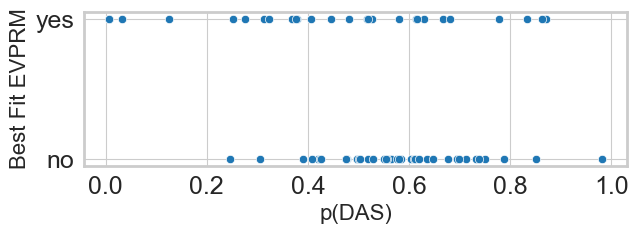

In [20]:
plt.figure(figsize=(7,2))
sns.scatterplot(data=dfDASFirst, x='p(DAS)', y='best_fit_EVPRM')

plt.ylabel('Best Fit EVPRM')
plt.yticks([0,1], ['no', 'yes'])
plt.show()

#### perform paired $t$-tests
<u>Alternatives:</u>
- p(DAS): less $\to$ due to the repetition bias p(DAS) should increase throughout the experiment
- reward: less $\to$ due to learning effect participants should improve in performance
- RT: greater $\to$ due to repetition bias and learning participants should respond faster
- time outs: greater $\to$ due to learning participants should produce less time outs

In [22]:
# perform paired t-test
def calculate_paired_ttest(df, measure, groupby, alternative):
    df = df[measure].groupby([df['Participant_ID'], df[groupby]]).mean().reset_index()

    stat, p = shapiro(df.loc[df[groupby]==0, measure]-df.loc[df[groupby]==1, measure])
    print(f'Shapiro-Wilk test of normality for {measure}: p = {p}')

    result = pg.ttest(x=df.loc[df[groupby]==0, measure],
                    y=df.loc[df[groupby]==1, measure], 
                    paired=True, 
                    alternative=alternative)
    
    return result

# loop through the measures
def print_ttest_results(df, measures, groupby, alternatives):

    results = {} # preallocation

    for i in range(len(alternatives)):
        
        result = calculate_paired_ttest(df, measures[i], groupby, alternatives[i])
        results[i] = result

        #print(f'{measures[i]} (alternative: {alternatives[i]})')
        #pg.print_table(result)
    
    return results

In [23]:
# define alternatives and perform t-tests
alternatives = ['less', 'less', 'greater', 'greater']
resultstTest = print_ttest_results(df, measures, 'half', alternatives)

# create a df with the rmANOVA results
stats = ['dof', 'T', 'p-val', 'cohen-d', 'alternative'] # select relevant statistics

dftTests = pd.DataFrame(measures, columns=['measure'])

dftTests[stats] = 0 # preallocation

for m in range(len(resultstTest)):
    dftTests.iloc[m, 1:] = resultstTest[m][stats].to_numpy().flatten()

dftTests.round(3)

Shapiro-Wilk test of normality for DAS: p = 1.0
Shapiro-Wilk test of normality for reward: p = 1.0
Shapiro-Wilk test of normality for RT: p = 1.0
Shapiro-Wilk test of normality for time_out: p = 1.0


,measure,dof,T,p-val,cohen-d,alternative
0,DAS,69,-1.617,0.055,0.100,less
1,reward,69,-4.575,0.000,0.351,less
2,RT,69,8.763,0.000,0.676,greater
3,time_out,69,4.859,0.000,0.661,greater


In [24]:
resultstTest

{0:                T  dof alternative     p-val        CI95%   cohen-d   BF10  \
 T-test -1.617219   69        less  0.055197  [-inf, 0.0]  0.100269  0.905   
 
            power  
 T-test  0.207779  ,
 1:                T  dof alternative    p-val          CI95%   cohen-d      BF10  \
 T-test -4.574644   69        less  0.00001  [-inf, -1.41]  0.351237  1805.183   
 
            power  
 T-test  0.897028  ,
 2:                T  dof alternative         p-val          CI95%   cohen-d  \
 T-test  8.762958   69     greater  4.032106e-13  [230.97, inf]  0.676497   
 
              BF10     power  
 T-test  2.021e+10  0.999962  ,
 3:                T  dof alternative     p-val        CI95%   cohen-d      BF10  \
 T-test  4.859447   69     greater  0.000004  [0.01, inf]  0.660884  4835.449   
 
            power  
 T-test  0.999936  }

<i>Note:</i> dof: degrees of freedom, T: $T$-value, p-val: $p$-value, cohen-d: Cohen's $d$

### create table for statistics depending on the segment of the experiment

In [25]:
dfSegments = df[measures].groupby([df['Participant_ID'], df['segment']]).mean().groupby('segment').agg(['mean', 'std']).round(2)
dfSegments

DAS       reward             RT         time_out      
         mean   std   mean   std     mean     std     mean   std
segment                                                         
0        0.53  0.22  76.42  7.58  2013.66  537.73     0.03  0.02
1        0.54  0.19  82.73  6.48  1632.43  414.64     0.01  0.01
2        0.54  0.20  81.26  6.87  1575.06  370.51     0.01  0.02
3        0.56  0.19  82.34  6.40  1496.83  450.28     0.01  0.01

#### Calculate rmANOVAs over segments

In [26]:
# perform paired t-test (x: first half, y: second half)
def calculate_rmANOVA(df, measure):

    result = pg.rm_anova(data=df,
                         dv=measure, 
                         within=['segment'], 
                         subject='Participant_ID')
    
    return result

# loop through the performance measures
def print_rmANOVA_results(df, measures):

    results = {} # preallocation

    for i, m in enumerate(measures):
        # calculate rmANOVA and save result
        result = calculate_rmANOVA(df, m)
        results[i] = result

        # print the results
        #print(f'{m}')
        #pg.print_table(result)
        
    return results

In [27]:
# perform rmANOVAs
rmANOVAResults = print_rmANOVA_results(df, measures)

# create a df with the rmANOVA results
stats = ['ddof1', 'ddof2', 'F', 'p-unc', 'ng2', 'eps'] # select relevant statistics

dfANOVA = pd.DataFrame(measures, columns=['measure'])

dfANOVA[stats] = 0 # preallocation

for m in range(len(rmANOVAResults)):
    dfANOVA.iloc[m, 1:] = rmANOVAResults[m][stats].to_numpy().flatten()

# print results
dfANOVA.round(3)

/Users/Eric/miniconda3/envs/pymc_env/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,measure,ddof1,ddof2,F,p-unc,ng2,eps
0,DAS,3,207,1.524,0.209,0.003,0.924
1,reward,3,207,40.168,0.000,0.121,0.933
2,RT,3,207,68.576,0.000,0.167,0.839
3,time_out,3,207,23.979,0.000,0.162,0.903


<i>Note:</i> ddof: degrees of freedom, F: $F$-value, p-unc: uncorrected $p$-value, ng2: generalized eta-squared $\eta^2_G$, eps: Greenhouse-Geisser epsilon factor (i.e. index of sphericity)

### create table for statistics depending on bonus condition

In [28]:
# get indicator of bonus trials and add it to the dataframe
bonusBlocks = np.array([1,0,0,1,1,0,1,0,1,1,0,0,1,1,0,0])
df['bonus'] = bonusBlocks[df['blockN'].to_numpy(dtype=np.int8)]

In [29]:
df[measures].groupby([df['Participant_ID'], df['bonus']]).mean().groupby('bonus').agg(['mean', 'std']).round(3)

DAS         reward               RT          time_out       
        mean    std    mean    std      mean      std     mean    std
bonus                                                                
0      0.518  0.192  80.036  5.919  1662.763  407.689    0.013  0.012
1      0.568  0.191  81.341  6.636  1691.794  405.107    0.016  0.016

In [30]:
df['time_out'].groupby([df['Participant_ID'], df['bonus']]).sum().groupby('bonus').agg(['mean', 'std'])

,mean,std
bonus,,
0,2.142857,1.905642
1,2.600000,2.492888


#### perform paired $t$-tests
<u>Alternatives:</u>
- p(DAS): less $\to$ due to bonus for DAS
- reward: less $\to$ due to bonus
- RT: greater $\to$ due to higher p(DAS)
- time outs: greater $\to$ due to higher p(DAS)

In [31]:
# define alternatives and perform t-tests
alternatives = ['less', 'less', 'greater', 'greater']
resultstTest = print_ttest_results(df, measures, 'bonus', alternatives)

# create a df with the t-test results
stats = ['dof', 'T', 'p-val', 'cohen-d', 'alternative'] # select relevant statistics

dftTests = pd.DataFrame(measures, columns=['measure'])

dftTests[stats] = 0 # preallocation
dftTests['CI_low'] = 100
dftTests['CI_high'] = 0

for m in range(len(resultstTest)):
    dftTests.loc[m, 'dof':'alternative'] = resultstTest[m][stats].to_numpy().flatten()

    # add 95% CI
    dftTests.loc[m, 'CI_low'] = np.hstack(resultstTest[m]['CI95%'].to_numpy())[0]
    dftTests.loc[m, 'CI_high'] = np.hstack(resultstTest[m]['CI95%'].to_numpy())[1]    

dftTests.round(3)

Shapiro-Wilk test of normality for DAS: p = 1.0
Shapiro-Wilk test of normality for reward: p = 1.0
Shapiro-Wilk test of normality for RT: p = 1.0
Shapiro-Wilk test of normality for time_out: p = 1.0


,measure,dof,T,p-val,cohen-d,alternative,CI_low,CI_high
0,DAS,69,-4.681,0.000,0.259,less,-inf,-0.03
1,reward,69,-2.838,0.003,0.208,less,-inf,-0.54
2,RT,69,-1.555,0.938,0.071,greater,-60.16,inf
3,time_out,69,-1.559,0.938,0.206,greater,-0.01,inf


## 2 Analyze $p$(DAS)
Calculate the proportion of the proposed default action sequence (DAS) and check if the DAS was the sequence that was used most frequently by the participants.

In [32]:
# calculate p(DAS) of each participant
dfDASMeans = df['DAS'].groupby(df['Participant_ID']).mean().rename('DAS_mean').reset_index()

# print mean and SD of p(DAS)
print(f"p(DAS): mean={dfDASMeans['DAS_mean'].mean().round(2)} (SD={dfDASMeans['DAS_mean'].std()})")

p(DAS): mean=0.54 (SD=0.18622740542713576)


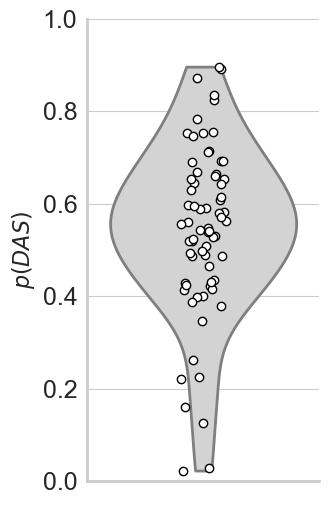

In [33]:
# plot the distribution
plt.figure(figsize=(3,6))
sns.violinplot(data=dfDASMeans, y='DAS_mean', cut=0, inner=None, color='lightgrey')
sns.stripplot(data=dfDASMeans, y='DAS_mean', size=6, edgecolor='black', linewidth=1, color='white')
plt.ylim([0,1])
plt.ylabel(r'$p(DAS)$', fontsize=16)
sns.despine()
plt.show()

In [34]:
# get the most frequently used sequence of actions of each participant
df['sequence_ID'].groupby(df['Participant_ID']).value_counts().rename('count').reset_index().groupby('Participant_ID').first()['sequence_ID'].to_numpy() #.unique()

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4., 19.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  0.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
       21.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4., 21.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.])

$\to$ Nearly all participants used the DAS (sequence ID 4) most frequently. Therefore we focus on the DAS for the subsequent analyses that test for the repetition bias.

## 3 Calculate the repetition bias measures
### 1) Increase in DAS use when DAS is not optimal
Due to the difference of 10 between possible points of the circles, an absolute difference between the DAS points and the goal of 5 makes the DAS one of the sequences of actions with the highest reward, i.e. an optimal sequence.

Here we check, if we can find an increase in DAS usage over time for trials where the DAS is not optimal.
#### preparatory work

In [35]:
# load the goals to define DAS optimality
goals = np.genfromtxt('../data_task/goals.csv', delimiter=',')

# add DAS optimality column
df['DAS_optimal'] = np.where(np.tile(np.abs(goals)<=5, len(set((df['Participant_ID'])))), 1, 0)

#### summary statistics

In [36]:
df['DAS'].groupby([df['DAS_optimal'], df['half']]).agg(['mean', 'std'])

mean       std
DAS_optimal half                    
0           0     0.352855  0.477897
            1     0.353423  0.478071
1           0     0.764840  0.424143
            1     0.807977  0.393932

In [37]:
df['DAS'].groupby([df['DAS_optimal'], df['segment']]).agg(['mean', 'std'])

mean       std
DAS_optimal segment                    
0           0        0.370553  0.483033
            1        0.335583  0.472270
            2        0.350917  0.477334
            3        0.355927  0.478870
1           0        0.732973  0.442498
            1        0.796457  0.402716
            2        0.795305  0.403562
            3        0.820608  0.383759

#### test for increase over halves

In [38]:
pg.rm_anova(data=df, dv='DAS', within=['DAS_optimal', 'half'], subject='Participant_ID').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,DAS_optimal,13.091,1,69,13.091,239.894,0.000,0.000,0.474,1.0
1,half,0.037,1,69,0.037,3.878,0.053,0.053,0.003,1.0
2,DAS_optimal * half,0.032,1,69,0.032,7.459,0.008,0.008,0.002,1.0


#### test for increase over segments

In [39]:
pg.rm_anova(data=df, dv='DAS', within=['DAS_optimal', 'segment'], subject='Participant_ID').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,DAS_optimal,26.138,1,69,26.138,239.149,0.000,0.000,0.451,1.000
1,segment,0.108,3,207,0.036,2.364,0.072,0.077,0.003,0.929
2,DAS_optimal * segment,0.247,3,207,0.082,11.157,0.000,0.000,0.008,0.868


### 2)  Increase in partial DAS use

#### preparatory work

In [40]:
# create partial DAS column -> partial DAS: at least the first move is in line with the DAS
firstMoveDAS = '0'
df['partial_DAS'] = np.where(df['movesTrial'].str[1]==firstMoveDAS, 1, 0)

#### summary statistics

In [48]:
df['partial_DAS'].groupby(df['half']).agg(['mean', 'std'])

,mean,std
half,,
0,0.628125,0.483327
1,0.716071,0.450923


In [49]:
df['partial_DAS'].groupby(df['segment']).agg(['mean', 'std'])

,mean,std
segment,,
0,0.598571,0.490231
1,0.657679,0.474529
2,0.707321,0.455033
3,0.724821,0.446644


#### test for increase over halves

In [50]:
stat, p = shapiro(df.loc[(df['half']==0) & (df['time_out']==0), 'partial_DAS'].groupby(df['Participant_ID']).mean()-df.loc[(df['half']==1) & (df['time_out']==0), 'partial_DAS'].groupby(df['Participant_ID']).mean())
print(f'Shapiro-Wilk test of normality: p = {p}')

pg.ttest(x=df.loc[(df['half']==0) & (df['time_out']==0), 'partial_DAS'].groupby(df['Participant_ID']).mean(), 
         y=df.loc[(df['half']==1) & (df['time_out']==0), 'partial_DAS'].groupby(df['Participant_ID']).mean(), 
         paired=True, 
         alternative='less').round(3)

Shapiro-Wilk test of normality: p = 0.18206921440300178


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.463,69,less,0.0,"[-inf, -0.06]",0.488,1.96e+06,0.992


#### test for increase over segments

In [51]:
pg.rm_anova(data=df.loc[df['time_out']==0], 
            dv='partial_DAS', 
            within=['segment'], 
            subject='Participant_ID')

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,segment,3,207,19.531461,3.441540e-11,0.059034,0.918202


#### Plot results

In [52]:
mpl.rcParams['axes.edgecolor'] = 'black'     # Farbe der linken Achse
mpl.rcParams['axes.linewidth'] = 1.5

In [53]:
def just_horizontal_grid():
    axs[0].yaxis.grid(True)
    axs[0].xaxis.grid(False)
    axs[1].yaxis.grid(True)
    axs[1].xaxis.grid(False)

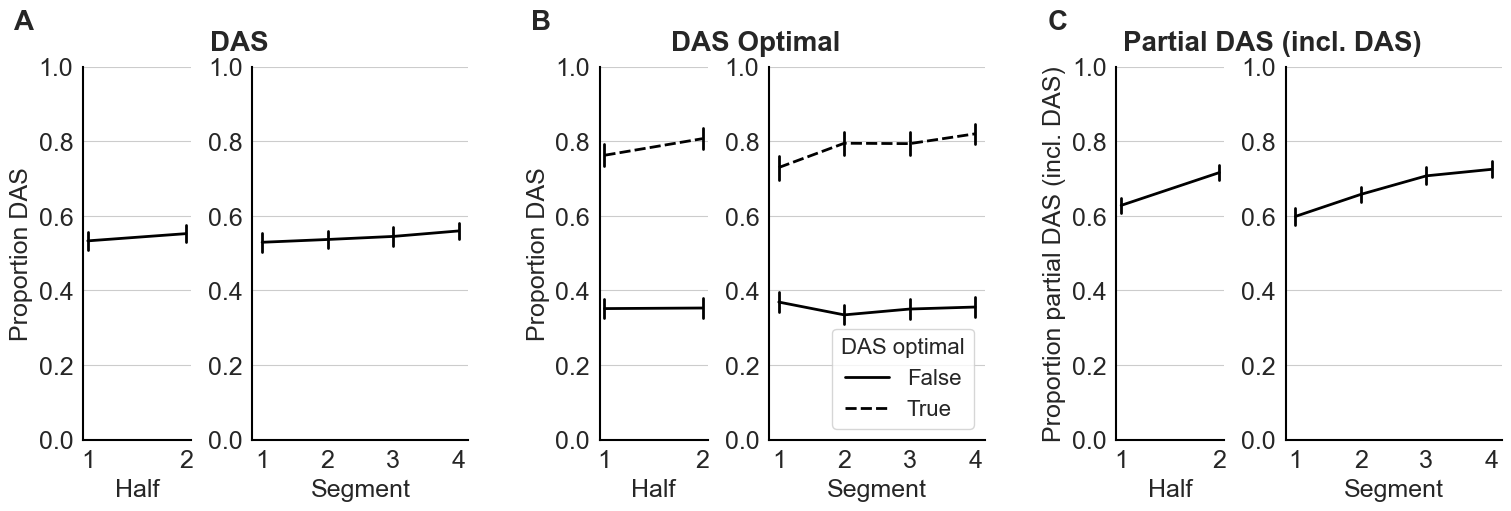

In [ ]:
fig = plt.figure(figsize=(15,5), layout='constrained')
subFigs = fig.subfigures(1,3, wspace=.1)

# A) DAS PROPORTION p(DAS)
subFig = subFigs[0]

subFig.suptitle('DAS', fontsize=20, fontweight='bold', y=.95)

axs = subFig.subplots(1,2, gridspec_kw={'width_ratios':[1,2]})

# DAS halves and segments
sns.lineplot(data=df['DAS'].groupby([df['Participant_ID'], df['half']], observed=True).mean().rename('DAS_mean').reset_index(), 
             x='half', 
             y='DAS_mean', 
             errorbar='se', err_style='bars', color='black', ax=axs[0])

sns.lineplot(data=df['DAS'].groupby([df['Participant_ID'], df['segment']], observed=True).mean().rename('DAS_mean').reset_index(),
              x='segment', 
              y='DAS_mean', 
              errorbar='se', err_style='bars', color='black', ax=axs[1]) 

axs[0].set_ylabel('Proportion DAS', fontsize=18)
axs[0].set_xlabel('Half', fontsize=18)
axs[0].set_xticks(np.arange(2), np.arange(1,3))

axs[1].set_xlabel('Segment', fontsize=18)
axs[1].set_xticks(np.arange(4), np.arange(1,5))
axs[1].set_ylabel('')

just_horizontal_grid()

[ ax.set_ylim([0,1]) for ax in axs.ravel() ]

# Add text 'A' to the upper left corner of axs[0]
axs[0].text(-.75, 1.10, 'A', fontsize=20, weight='bold')


# B) DAS OPTIMAL

subFig = subFigs[1]

subFig.suptitle('DAS Optimal', fontsize=20, fontweight='bold', y=.95)

axs = subFig.subplots(1,2, gridspec_kw={'width_ratios':[1,2]})

sns.lineplot(data=df['DAS'].groupby([df['Participant_ID'], df['DAS_optimal'], df['half']], observed=True).mean().rename('DAS_mean').reset_index(), 
             x='half', 
             y='DAS_mean', 
             style='DAS_optimal', errorbar='se', err_style='bars', color='black', legend=False, ax=axs[0])

sns.lineplot(data=df['DAS'].groupby([df['Participant_ID'], df['DAS_optimal'], df['segment']], observed=True).mean().rename('DAS_mean').reset_index(), 
             x='segment',
             y='DAS_mean', 
             style='DAS_optimal', errorbar='se', err_style='bars', color='black', ax=axs[1])

axs[0].set_ylabel('Proportion DAS', fontsize=18)
axs[0].set_xlabel('Half', fontsize=18)
axs[0].set_xticks(np.arange(2), np.arange(1,3))
#axs[0].legend(labels=('False', 'True'), title='DAS optimal', title_fontsize=12, fontsize=12, loc='lower right')

axs[1].set_ylabel('')
axs[1].set_xlabel('Segment', fontsize=18)
axs[1].set_xticks(np.arange(4), np.arange(1,5))
axs[1].legend(labels=('False', 'True'), title='DAS optimal', title_fontsize=16, fontsize=16, loc='lower right')

just_horizontal_grid()

[ ax.set_ylim([0,1]) for ax in axs.ravel() ]

# Add text to the upper left corner
axs[0].text(-.75, 1.10, 'B', fontsize=20, weight='bold') 

# C) PARTIAL DAS

subFig = subFigs[2]

subFig.suptitle('Partial DAS (incl. DAS)', fontsize=20, fontweight='bold', y=.95)

axs = subFig.subplots(1,2, gridspec_kw={'width_ratios':[1,2]})

# partial DAS halves and segments
sns.lineplot(data=df['partial_DAS'].groupby([df['Participant_ID'], df['half']], observed=True).mean().rename('part_DAS_mean').reset_index(), 
             x='half',
             y='part_DAS_mean', 
             errorbar='se', err_style='bars', color='black', linewidth=2, ax=axs[0])

sns.lineplot(data=df['partial_DAS'].groupby([df['Participant_ID'], df['segment']], observed=True).mean().rename('part_DAS_mean').reset_index(),
              x='segment',
              y='part_DAS_mean',  
              errorbar='se', err_style='bars', color='black', linewidth=2, ax=axs[1])

axs[0].set_ylabel('Proportion partial DAS (incl. DAS)', fontsize=18)
axs[0].set_xlabel('Half', fontsize=18)
axs[0].set_xticks(np.arange(2), np.arange(1,3))

axs[1].set_xlabel('Segment', fontsize=18)
axs[1].set_xticks(np.arange(4), np.arange(1,5))
axs[1].set_ylabel('')

just_horizontal_grid()

[ ax.set_ylim([0,1]) for ax in axs.ravel() ]

# Add text to the upper left corner
axs[0].text(-.75, 1.10, 'C', fontsize=20, weight='bold')

sns.despine()

#plt.savefig('../figures/p_DAS.svg', format='svg')

#plt.tight_layout()
plt.show()

### 3) Decrease in number of used sequences

#### preparatory work

In [56]:
# get the unique sequences for each participant at each of the segments
dfSequencesSegments = df['sequence_ID'].groupby([df['Participant_ID'], df['segment']]).unique().rename('unique_sequences').reset_index()
dfSequencesHalves = df['sequence_ID'].groupby([df['Participant_ID'], df['half']]).unique().rename('unique_sequences').reset_index()

# Function to remove 'nan' values from a numpy array
def remove_nan_from_list(lst):
    return [value for value in lst if not np.isnan(value)]

# delete nan entries from df
dfSequencesSegments['unique_sequences'] = dfSequencesSegments['unique_sequences'].apply(remove_nan_from_list)
dfSequencesHalves['unique_sequences'] = dfSequencesHalves['unique_sequences'].apply(remove_nan_from_list)

# count how many different sequences were used at each segment
dfSequencesSegments['n_unique_sequences'] = dfSequencesSegments['unique_sequences'].apply(lambda x: len(x))
dfSequencesHalves['n_unique_sequences'] = dfSequencesHalves['unique_sequences'].apply(lambda x: len(x))

#### summary statistics

In [57]:
dfSequencesHalves['n_unique_sequences'].groupby(dfSequencesHalves['half']).agg(['mean', 'std']).round(2)

,mean,std
half,,
0,16.87,5.94
1,15.30,5.58


In [58]:
dfSequencesSegments['n_unique_sequences'].groupby(dfSequencesSegments['segment']).agg(['mean', 'std']).round(2)

,mean,std
segment,,
0,12.71,5.07
1,10.61,4.39
2,11.14,4.24
3,10.31,4.70


#### test for decrease over halves

In [59]:
stat, p = shapiro(dfSequencesHalves.loc[dfSequencesHalves['half']==0, 'n_unique_sequences']-dfSequencesHalves.loc[dfSequencesHalves['half']==1, 'n_unique_sequences'])
print(f'Shapiro-Wilk test of normality: p = {p}')

pg.ttest(x=dfSequencesHalves.loc[dfSequencesHalves['half']==0, 'n_unique_sequences'], 
         y=dfSequencesHalves.loc[dfSequencesHalves['half']==1, 'n_unique_sequences'], 
         paired=True, 
         alternative='greater').round(3)

Shapiro-Wilk test of normality: p = 1.0


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.526,69,greater,0.0,"[0.83, inf]",0.273,65.571,0.73


#### test for decrease over segments

In [60]:
# perform rmANOVA
pg.rm_anova(data=dfSequencesSegments, 
            dv='n_unique_sequences', 
            within=['segment'], 
            subject='Participant_ID').round(3)

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,segment,3,207,13.884,0.0,0.039,0.963


#### calculate correlation between decrease over halves and reward difference

In [61]:
# add mean reward to df
dfSequencesHalves['reward'] = df['reward'].groupby([df['Participant_ID'], df['half']]).mean().rename('mean_reward').reset_index()['mean_reward']

# calculate differences of no. of sequences and rewards
dfSequencesHalvesDiffs = dfSequencesHalves.loc[dfSequencesHalves['half']==1, 
                                               ['n_unique_sequences', 'reward']].reset_index()-dfSequencesHalves.loc[dfSequencesHalves['half']==0, 
                                                ['n_unique_sequences', 'reward']].reset_index()

In [62]:
pg.corr(x=dfSequencesHalvesDiffs['n_unique_sequences'], 
        y=dfSequencesHalvesDiffs['reward'])

,n,r,CI95%,p-val,BF10,power
pearson,70,-0.376205,"[-0.56, -0.15]",0.001329,23.169,0.902994


#### Plot results

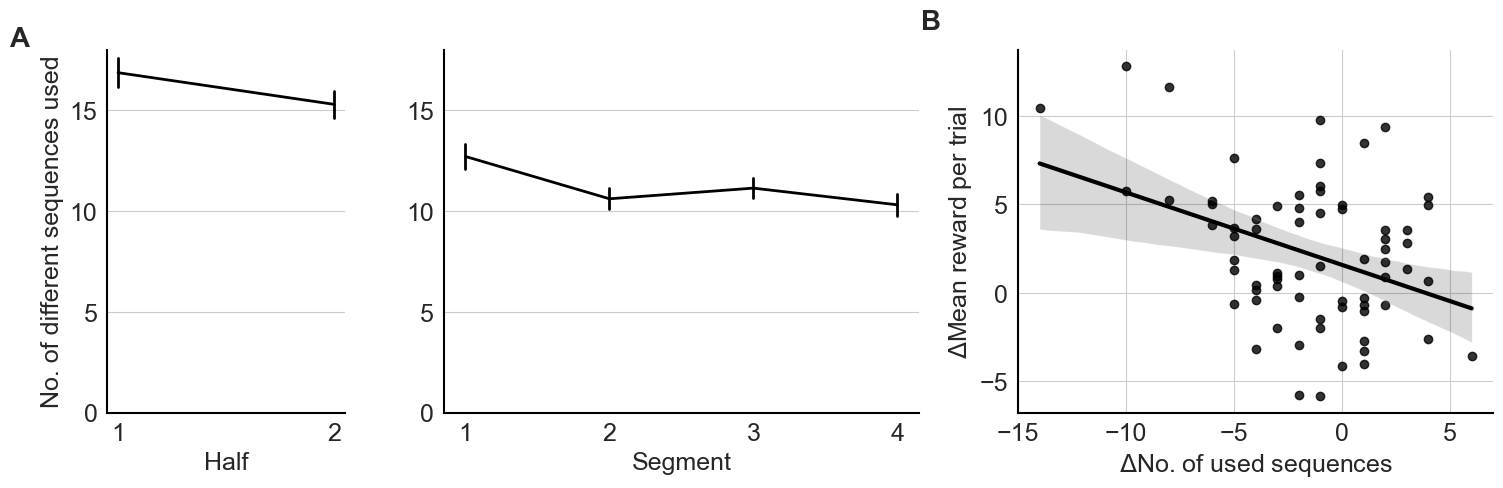

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), width_ratios=[1,2,2])

# A) used sequences depending on halves
sns.lineplot(data=dfSequencesHalves, x='half', y='n_unique_sequences', errorbar='se', err_style='bars', color='black', ax=axs[0])
axs[0].set_ylabel('No. of different sequences used', fontsize=18)
axs[0].set_xlabel('Half', fontsize=18)
axs[0].set_xticks([0,1], ['1', '2'])
axs[0].set_ylim([0, 18]) #[14,18])
axs[0].yaxis.grid(True)
axs[0].xaxis.grid(False)
axs[0].text(-.5, 18.2, 'A', fontsize=20, weight='bold')

# B) used sequences depending on segments
sns.lineplot(data=dfSequencesSegments, x='segment', y='n_unique_sequences', errorbar='se', err_style='bars', color='black', ax=axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('Segment', fontsize=18)
axs[1].yaxis.grid(True)
axs[1].xaxis.grid(False)
axs[1].set_xticks(np.arange(4), np.arange(4)+1)
axs[1].set_ylim([0, 18]) #[9,13.5])

# C) correlation of differences of used sequences and mean reward
sns.regplot(data=dfSequencesHalvesDiffs, x='n_unique_sequences', y='reward', color='black', ax=axs[2])
axs[2].set_xlabel(r'$\Delta$No. of used sequences', fontsize=18)
axs[2].set_ylabel(r'$\Delta$Mean reward per trial', fontsize=18)
axs[2].text(-19.5, 14.9, 'B', fontsize=20, weight='bold')

#plt.savefig('../figures/n_sequences.svg', format='svg')

sns.despine()
plt.tight_layout()
plt.show()

In [53]:
# print date of last changes and version numbers
%load_ext watermark

%watermark -n -u -v -iv -w

Last updated: Mon Jan 06 2025

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.20.0

numpy     : 1.25.2
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
seaborn   : 0.12.2
pandas    : 2.2.1
matplotlib: 3.8.4
pingouin  : 0.5.4

Watermark: 2.3.1

